<a href="https://colab.research.google.com/github/ravindrabharathi/Project1/blob/master/Session6/Assignment_6B.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Image Classification using CIFAR 10 dataset 

###Import necessary Modules 

In [0]:
from keras import backend as K
import time
import matplotlib.pyplot as plt
import numpy as np
% matplotlib inline
np.random.seed(2017) 
from keras.models import Sequential
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.layers import Activation, Flatten, Dropout
from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils

Using TensorFlow backend.


###create train and test data using cifar10 dataset in Keras 

In [0]:
from keras.datasets import cifar10
(train_features, train_labels), (test_features, test_labels) = cifar10.load_data()
num_train, img_channels, img_rows, img_cols =  train_features.shape
num_test, _, _, _ =  test_features.shape
num_classes = len(np.unique(train_labels))

170500096/170498071 [==============================] - 4s 0us/step


###Plot some of the images in the dataset along with class label

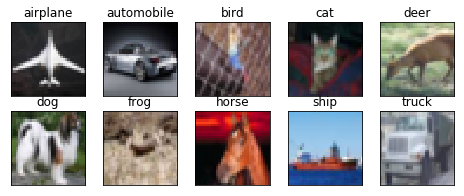

In [0]:
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']
fig = plt.figure(figsize=(8,3))
for i in range(num_classes):
    ax = fig.add_subplot(2, 5, 1 + i, xticks=[], yticks=[])
    idx = np.where(train_labels[:]==i)[0]
    features_idx = train_features[idx,::]
    img_num = np.random.randint(features_idx.shape[0])
    im = features_idx[img_num]
    ax.set_title(class_names[i])
    plt.imshow(im)
plt.show()

###define function to plot accuracy vs number of epoch and loss vs number of epochs

In [0]:
def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['acc'])+1),model_history.history['acc'])
    axs[0].plot(range(1,len(model_history.history['val_acc'])+1),model_history.history['val_acc'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['acc'])+1),len(model_history.history['acc'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()

###function to return accuracy given the model, and test data

In [0]:
def accuracy(test_x, test_y, model):
    result = model.predict(test_x)
    predicted_class = np.argmax(result, axis=1)
    true_class = np.argmax(test_y, axis=1)
    num_correct = np.sum(predicted_class == true_class) 
    accuracy = float(num_correct)/result.shape[0]
    return (accuracy * 100)

###function to return max training accuracy given the model history 

In [0]:
def max_accuracy(model_info):
    train_acc=model_info.history['acc']
    max_train_acc=max(train_acc)
    return (max_train_acc * 100)

###Scale the input features to be within 0 and 1 
###convert the train and test labels to 10 class category format 

In [0]:
train_features = train_features.astype('float32')/255
test_features = test_features.astype('float32')/255
# convert class labels to binary class labels
train_labels = np_utils.to_categorical(train_labels, num_classes)
test_labels = np_utils.to_categorical(test_labels, num_classes)

##Define the Model 

### The model will have a Normal convolution layer of 32 3x3 kernels 
### in Convolution Block 1 , we will use the concept of [Separable convolutions](https://towardsdatascience.com/a-basic-introduction-to-separable-convolutions-b99ec3102728) 
### Convolution Block 1 will use Spatially separable convolution of 3x1 followed by 1x3 with an output of 64 channels . 
### This spatially separable convolution will be followed by a depthwise separable convolution with 128 activation channels 
### Conv Block 1 is followed by a Transition layer of 1x1 convolution to reduce the 128 channels to 32 , followed by downsampling using 2x2 Maxpooling 

### in the following two blocks we will use Grouped Convolutions or filter groups .Grouped convolutions were introduced in the famous [AlexNet paper](https://papers.nips.cc/paper/4824-imagenet-classification-with-deep-convolutional-neural-networks) of 2012

### Conv Block 2 consists of Grouped Convolution with blocks of 64 3x3 and 64 5x5 kernels . These two blocks are concatenated to give 128 activation channels of block 2

### Transition Block 2 consisting of 32 1x1 and Max Pooling follows Block 2

### Conv Block 3 consists of Grouped Convolution with blocks of 64 3x3 kernels with dilation 1 and 64 3x3  kernels with dilation rate 2 . Dilation or Atrous convolution helps the network gather a better global context and was first used in this [paper](https://arxiv.org/abs/1412.7062)  and again in this [paper ](https://arxiv.org/abs/1511.07122)
####Atrous convolution gets its concept from 'a trous algorithm' which had been in use for long in Wavelet transforms . 'a trous algorithm' loosely translates from French as 'hole algorithm' and gets its name due to the gaps formed as a result of the dilations.  

### These two blocks are concatenated to give 128 activation channels of block 3

### The 128 Channels from Block 3 are squashed to 10 channels using 1x1 pointwise convolution 

### The last layer before Flattening and Softmax activation is a 7x7 kernel convolution 

In [0]:
from keras.layers.convolutional import Conv2D
from keras.layers import Input, SeparableConv2D,BatchNormalization
from keras.layers.advanced_activations import ReLU
from keras.models import Model,  load_model
from keras.layers.merge import concatenate

#input layer size 32 x 32 and 3 color channels 
input_layer = Input(shape=(32, 32, 3))

#Add first ayer of Normal convolution 3 x 3 size kernel, ReLU activation , padding = same 

layer1 = Conv2D(32, 3, padding='same',bias=False,name='layer1' ) (input_layer) 
layer1 = BatchNormalization()(layer1)
layer1 = ReLU()(layer1)

#Block1 

#Add Spatially Separable Convolution of 3x1 followed by 1x3 

block1=Conv2D(64,(3,1), bias=False, name='block1_layer1') (layer1)
block1=BatchNormalization()(block1)
block1=ReLU()(block1)
block1=Conv2D(64,(1,3), bias=False,name='block1_layer2') (block1)
block1=BatchNormalization()(block1)
block1=ReLU()(block1)

#Add Depthwise Separable Convolution

block1=SeparableConv2D(128,3, bias=False,name='block1_layer3')(block1)
block1=BatchNormalization()(block1)
block1=ReLU()(block1)

#dropout after conv block1 
block1=Dropout(0.05)(block1)


#Transition Block 1
trans_block1=(Conv2D(32,1, bias=False,name='trans_blk1_ptwise'))(block1)
trans_block1=BatchNormalization()(trans_block1)
trans_block1=ReLU()(trans_block1)
trans_block1=MaxPooling2D(pool_size=(2, 2),name='trans_blk1_MP')(trans_block1)                          



#Conv Block 2 
# Grouped Convolution 

#first filter group 64 3x3 
block2_1= (Conv2D(64,3, padding='same', bias=False,name='block2_1'))(trans_block1)
block2_1=BatchNormalization()(block2_1)
block2_1= ReLU()(block2_1)

#second filter group 64 5x5 
block2_2= (Conv2D(64,5, padding='same', bias=False,name='block2_2'))(trans_block1)
block2_2= BatchNormalization()(block2_2)
block2_2= ReLU()(block2_2)

#concatenate the two groups to form block 2 activation channels 

block2 = concatenate([block2_1,block2_2])


#dropout after conv block2
block2=Dropout(0.05)(block2)

#Transition Block 1
trans_block2=(Conv2D(32,1, bias=False,name='trans_blk2_ptwise'))(block2)
trans_block2=BatchNormalization()(trans_block2)
trans_block2=ReLU()(trans_block2)
trans_block2=MaxPooling2D(pool_size=(2, 2),name='trans_blk2_MP')(trans_block2)                                     

# conv Block 3

#Grouped Convolution with dilated conv layers 

#filter group 1 is 64 3x3 filters with no dilation or dilation rate set to 1
block3_1= (Conv2D(64,3, dilation_rate=1, border_mode='same', bias=False,name='block3_1'))(trans_block2)
block3_1= BatchNormalization()(block3_1)
block3_1= ReLU()(block3_1)


#filter group 2 is 64 3x3 filters with dilation rate set to 2 i.e filter cells dilated by a gap of 1 cell between them 
block3_2= (Conv2D(64,3, dilation_rate=2, border_mode='same', bias=False,name='block3_2'))(trans_block2)
block3_2= BatchNormalization()(block3_2)
block3_2= ReLU()(block3_2)

#concatenate the two block3 groups to give block3 activation channels 
block3 = concatenate([block3_1,block3_2])

#dropout after conv block3
block3=Dropout(0.05)(block3)

#Pointwise convolution to squash 192 channels to 10 output channels 
trans_block3=(Conv2D(10,1, bias=False,name='trans_blk3_ptwise'))(block3)
trans_block3=BatchNormalization()(trans_block3)
trans_block3=ReLU()(trans_block3)

#last conv layer - filter size 7, No ReLU activation , no BatchNormalization
last_layer= (Conv2D(10,7, bias=False,name='last_layer'))(trans_block3)                                                        #47

#Flatten the output 
flat_layer=(Flatten())(last_layer)

#Softmax activation to output likelihood values for classes 

output=Activation('softmax')(flat_layer)

#Assign the Model input and output

model = Model(inputs=[input_layer], outputs=[output])

#Print model summary 

model.summary()




/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, 3, padding="same", name="layer1", use_bias=False)`
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 1), name="block1_layer1", use_bias=False)`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (1, 3), name="block1_layer2", use_bias=False)`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:29: UserWarning: Update your `SeparableConv2D` call to the Keras 2 API: `SeparableConv2D(128, 3, name="block1_layer3", use_bias=False)`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:38: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, 1, name="trans_blk1_ptwise", use_bias=False)`
/usr/local/lib/python3.6/dist-packages/ipyke

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
layer1 (Conv2D)                 (None, 32, 32, 32)   864         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_12 (BatchNo (None, 32, 32, 32)   128         layer1[0][0]                     
__________________________________________________________________________________________________
re_lu_12 (ReLU)                 (None, 32, 32, 32)   0           batch_normalization_12[0][0]     
__________________________________________________________________________________________________
block1_lay

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:85: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(10, 1, name="trans_blk3_ptwise", use_bias=False)`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:90: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(10, 7, name="last_layer", use_bias=False)`


###Learning Rate Scheduler : We will add a custom learning rate scheduler that reduces the rate every 2nd epoch sugject to a min of 0.0005. We will also start with a slightly larger lr of 0.003 compared to default of 0.001 for Adam optimizer

In [0]:
# define a learning rate scheduler . We will use a simple scheduler that reduces the lr by 10% every 2 epochs subject to a minimum lr of 0.0005 
from keras.optimizers import Adam
from keras.callbacks import LearningRateScheduler
def scheduler(epoch, lr):
  if (epoch%2==0 and epoch):
    new_lr = max(0.9*lr,0.0005) 
  else:
    new_lr=lr
  
  return round(new_lr, 10)
  
 



In [0]:
#start with a higher lr of 0.003 
model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=0.003), metrics=['accuracy'])

###Image Augmentation : 
#### Define Imagedatagenerator with horizontal flip set to True ,zoom range of 0.15
#### Train the model for 100 epochs 
#### Plot accuracy vs number of epochs 
#### Plot loss vs number of epochs 
#### print validation accuracy
#### print max training accuracy 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras_pre..., validation_data=(array([[[..., callbacks=[<keras.ca..., verbose=1, steps_per_epoch=390, epochs=50)`
  if sys.path[0] == '':


Epoch 1/50

Epoch 00001: LearningRateScheduler setting learning rate to 0.003.
390/390 [==============================] - 27s 69ms/step - loss: 1.3137 - acc: 0.5222 - val_loss: 1.8471 - val_acc: 0.4118
Epoch 2/50

Epoch 00002: LearningRateScheduler setting learning rate to 0.003.
390/390 [==============================] - 25s 64ms/step - loss: 0.9140 - acc: 0.6737 - val_loss: 1.0370 - val_acc: 0.6440
Epoch 3/50

Epoch 00003: LearningRateScheduler setting learning rate to 0.0027.
390/390 [==============================] - 25s 64ms/step - loss: 0.7748 - acc: 0.7282 - val_loss: 0.9737 - val_acc: 0.6791
Epoch 4/50

Epoch 00004: LearningRateScheduler setting learning rate to 0.0027000001.
390/390 [==============================] - 25s 64ms/step - loss: 0.7044 - acc: 0.7536 - val_loss: 0.9429 - val_acc: 0.6767
Epoch 5/50

Epoch 00005: LearningRateScheduler setting learning rate to 0.0024300001.
390/390 [==============================] - 25s 64ms/step - loss: 0.6424 - acc: 0.7741 - val_loss: 

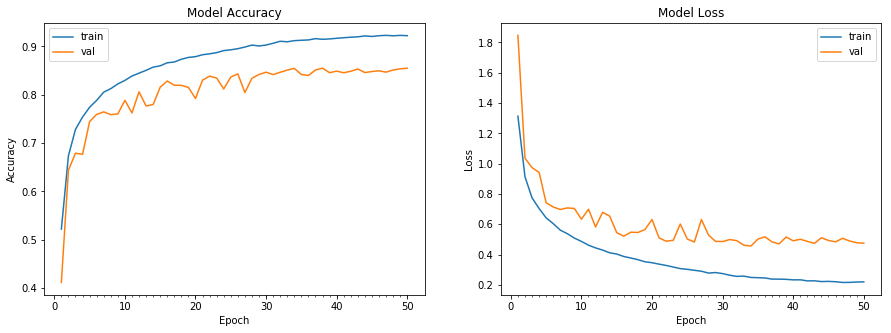


Accuracy on test data is: 85.48

Max Training Accuracy on training data is: 92.27


In [0]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(zoom_range=0.15, 
                             horizontal_flip=True)


# train the model
start = time.time()
# Train the model
model_info = model.fit_generator(datagen.flow(train_features, train_labels, batch_size = 128),
                                 samples_per_epoch = train_features.shape[0], nb_epoch = 50, 
                                 validation_data = (test_features, test_labels), callbacks=[LearningRateScheduler(scheduler, verbose=1)],verbose=1)
end = time.time()
print ("Model took %0.2f seconds to train\n"%(end - start))
# plot model history
plot_model_history(model_info)
# compute test accuracy
print ("\nAccuracy on test data is: %0.2f"%accuracy(test_features, test_labels, model))
print ("\nMax Training Accuracy on training data is: %0.2f"%max_accuracy(model_info))

### For building this Model , we used the following types of convolutions  :
#### Normal convolution with a 3x3 kernel 
#### Spatially Separable convolutions 
#### Depthwise Sepabale Convolutions
#### Grouped Convolutions
#### Dilated or Atrous convolution 

### We added the following to help the network learn optimally and avoid overfitting: 
####BatchNormalization , Dropouts of 5% , Higher learning rate with a simple learning rate scheduler and Image Augmentation 

### The model trained for 50 epochs and reached a max training accuracy of  92.27 and max validation accuracy of 85.48. Training more epochs would yield higher accuracies.